## Imports


In [1]:
from numpy import pi

import qutip as qt

from rich import print as pprint

import matplotlib
from matplotlib import colors, cm, patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from trical.light_matter import *
from trical.backend.qutip.base import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

muted_palette = sns.color_palette("muted", n_colors=10, desat=0.8)

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 10,
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
)
estate2 = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=1,
    energy=2 * np.pi * 200,
)

transitions = [
    Transition(
        level1=downstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=downstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 1],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

Yb171_2 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, -1],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

COM_x = Phonon(
    energy=2 * np.pi * 0.1, eigenvector=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2), 0, 0]
)

system = System(
    ions=[Yb171, Yb171_2],
    modes=[COM_x],
)

Omega = 2 * np.pi * 10
Delta = 2 * np.pi * 25
mu = 2 * np.pi * 0.12


beam = Beam(
    transition=transitions[0],
    rabi=Omega,
    detuning=Delta,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[-1, 0, 0],
    target=0,
)

beam2 = Beam(
    transition=transitions[2],
    rabi=Omega,
    detuning=Delta + mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

beam3 = Beam(
    transition=transitions[2],
    rabi=Omega,
    detuning=Delta - mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

beam4 = Beam(
    transition=transitions[0],
    rabi=Omega,
    detuning=Delta,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[-1, 0, 0],
    target=1,
)

beam5 = Beam(
    transition=transitions[2],
    rabi=Omega,
    detuning=Delta + mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)

beam6 = Beam(
    transition=transitions[2],
    rabi=Omega,
    detuning=Delta - mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)


beam7 = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 5,
    detuning=2 * np.pi * 25,
    phase=0,
    polarization=[1, 0, 0],
    wavevector=[0, 1, 0],
    target=0,
)

beam8 = Beam(
    transition=transitions[2],
    rabi=2 * pi * 5,
    detuning=2 * np.pi * 25,
    phase=0,
    polarization=[1, 0, 0],
    wavevector=[0, 1, 0],
    target=0,
)

protocol = SequentialProtocol(
    sequence=[
        # ParallelProtocol(
        #     sequence=[
        #         Pulse(beam=beam7, duration=1.3),
        #         Pulse(beam=beam8, duration=1.3),
        #     ]
        # ),
        ParallelProtocol(
            sequence=[
                Pulse(beam=beam, duration=5),
                Pulse(beam=beam2, duration=5),
                Pulse(beam=beam3, duration=5),
                Pulse(beam=beam4, duration=5),
                Pulse(beam=beam5, duration=5),
                Pulse(beam=beam6, duration=5),
            ]
        ),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [4]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("8_example_molmer_sorenson.json", "w") as f:
    f.write(circuit_json)

In [5]:
with open("8_example_molmer_sorenson.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [6]:
backend = QutipBackend()

fock_cutoff = 4
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

In [7]:
from oqd_compiler_infrastructure import Post

from trical.light_matter.visualization import CircuitPrinter

printer = Post(CircuitPrinter())

print(printer(backend.intermediate))

AtomicEmulatorCircuit
  - base: Operator(0.6283185307179586 * I @ I @ C * A + 1256.6370614359173 * I @ |3><3| @ I + 628.3185307179587 * I @ |2><2| @ I + 62.83185307179586 * I @ |1><1| @ I + 1256.6370614359173 * |3><3| @ I @ I + 628.3185307179587 * |2><2| @ I @ I + 62.83185307179586 * |1><1| @ I @ I)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator((10.241963774701599 * exp(1j * (-721.8123280887909 * t)) + (10.241963774701599 * exp(1j * (-723.3202925625139 * t)) + 11.995530829997286 * exp(1j * (785.3981633974483 * t)))) * I @ |3><1| @ exp(1j * 0.04823719159932803 * (A + C)) + (10.241963774701599 * exp(1j * (-721.8123280887909 * t)) + (10.241963774701599 * exp(1j * (-723.3202925625139 * t)) + 11.995530829997286 * exp(1j * (785.3981633974483 * t)))) * I @ |1><3| @ exp(1j * 0.04823719159932803 * (A + C)) + (10.241963774701599 * exp(1j * (721.8123280887909 * t)) + (10.241963774701599 * exp(1j * (723.3202925625139 * t)) + 11.995530829997286 * exp(1j * (-785.398163

In [8]:
%timeit experiment.base(0)
%timeit experiment.sequence[0].hamiltonian(0)

1.33 ms ± 12.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
18.8 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Results


In [9]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-2,
)

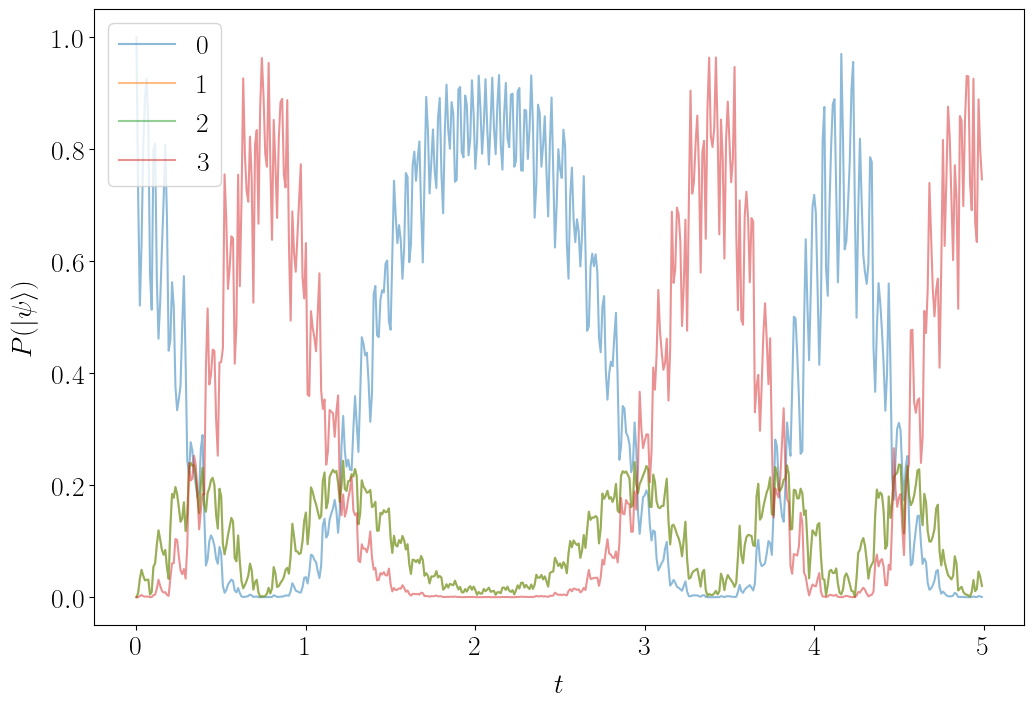

In [15]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

state_labels = [0, 1, 4, 5]
plot_states = [
    [s.ptrace([0, 1]).diag()[i] for i in state_labels] for s in result["states"][k]
]

ax.plot(
    result["tspan"][k],
    plot_states,
    label=range(len(state_labels)),
    alpha=0.5,
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

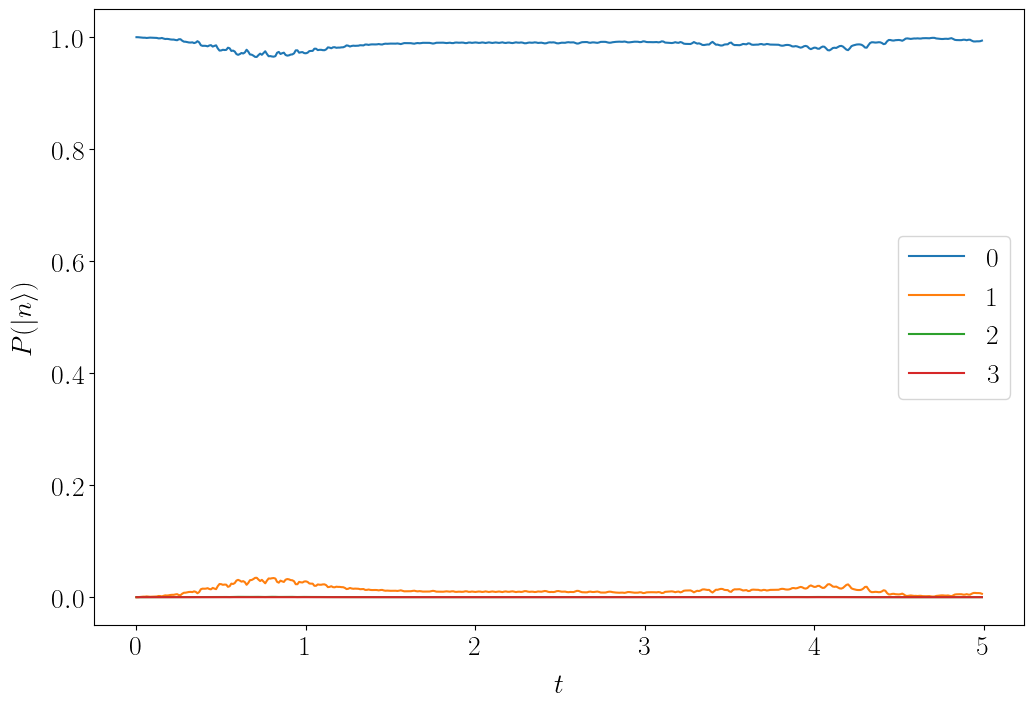

In [11]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(2).diag()[:4] for s in result["states"][k]],
    label=range(4),
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| n \rangle)$", labelpad=10)

ax.legend()